In [35]:
import numpy as np
import pandas as pd

from pyinform.dist import Dist
from statsmodels.tsa.arima_process import ArmaProcess
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

from scipy.stats import entropy

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.stattools import pacf 
from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mutual_info_score

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns

### $AR(1)$ 
#### $S_t = \mu + \phi_1 S_{t-1} + \epsilon_t$

In [62]:
np.random.seed(42)

ar = np.array([1, -0.9]) # MU(constant)=1, PHI=0.9 (MOMENTUM)
ma = np.array([1])

process = ArmaProcess(ar, ma)
series = process.generate_sample(1000, )

In [63]:
print(f'mu: {np.mean(series)}')
print(f'sigma: {np.std(series)}')
print(f'sigma2: {np.var(series)}')

mu: 0.19626089593974705
sigma: 2.241191499090931
sigma2: 5.022939335597455


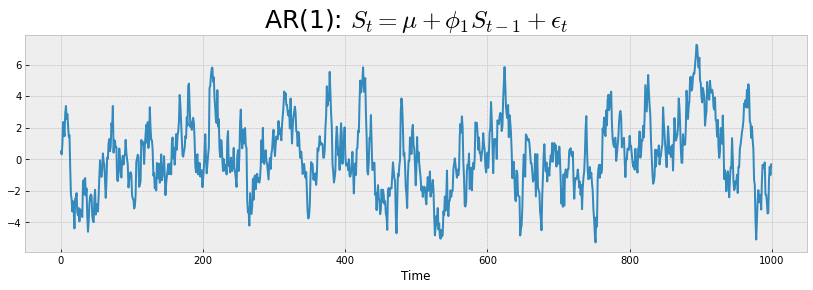

In [64]:
plt.figure(figsize=(14,4))
plt.title('AR(1): '+'$S_t = \mu + \phi_1 S_{t-1} + \epsilon_t$', fontsize=25)
plt.plot(series)
plt.xlabel('Time')
plt.show()

In [65]:
mod = ARIMA(series, order=(1, 0, 0))
res = mod.fit()

In [66]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1398.152
Date:                Sat, 14 Jan 2023   AIC                           2802.303
Time:                        17:03:13   BIC                           2817.027
Sample:                             0   HQIC                          2807.899
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1955      0.307      0.638      0.524      -0.406       0.797
ar.L1          0.8988      0.014     63.843      0.000       0.871       0.926
sigma2         0.9577      0.042     22.660      0.0

In [162]:
data = pd.DataFrame({'ar':series})
s_dict = {}
n_series = 5
for s in range(n_series):
    idx = s+1
    name = 'l'+str(idx)
    s_dict[name] = idx
    data[name] = data['ar'].shift(idx)
data.head()

,ar,l1,l2,l3,l4,l5
0,0.496714,NaN,NaN,NaN,NaN,NaN
1,0.308778,0.496714,NaN,NaN,NaN,NaN
2,0.925589,0.308778,0.496714,NaN,NaN,NaN
3,2.356060,0.925589,0.308778,0.496714,NaN,NaN
4,1.886301,2.356060,0.925589,0.308778,0.496714,NaN


In [161]:
data.corr()

,ar,l1,l2,l3,l4,l5
ar,1.000000,0.899631,0.810859,0.731175,0.656544,0.600965
l1,0.899631,1.000000,0.899659,0.810848,0.731196,0.657030
l2,0.810859,0.899659,1.000000,0.899668,0.810788,0.731381
l3,0.731175,0.810848,0.899668,1.000000,0.899701,0.811380
l4,0.656544,0.731196,0.810788,0.899701,1.000000,0.900009
l5,0.600965,0.657030,0.731381,0.811380,0.900009,1.000000


In [179]:
y_series = 'l4'

x = data['ar'].values
y = data[y_series].values

x = x[s_dict[y_series]:]
y = y[s_dict[y_series]:]

In [180]:
np.corrcoef(x, y)

array([[1.        , 0.65654426],
       [0.65654426, 1.        ]])

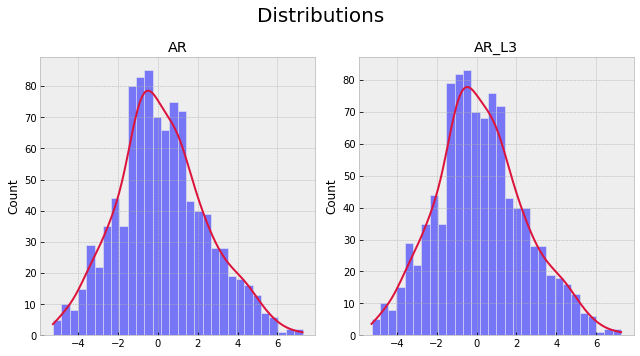

In [181]:
fig, axes = plt.subplots(1,2, figsize=(9,5))
bins = 30
line_color = 'crimson'

ax=axes[0]
sns.histplot(x, bins=bins, kde=True, ax=ax)
ax.lines[0].set_color(line_color)
ax.set_title('AR')

ax=axes[1]
sns.histplot(y, bins=bins, kde=True, ax=ax)
ax.lines[0].set_color(line_color)
ax.set_title('AR_L3')

plt.suptitle('Distributions', fontsize=20)
plt.tight_layout()
plt.show()

In [182]:
states = 10

pxy, xbin, ybin = np.histogram2d(x, y, bins=states)
print(f'Outcomes: {pxy.sum()}')
print(pxy.shape)
pxy

Outcomes: 996.0
(10, 10)


array([[ 5.,  5.,  7.,  4.,  2.,  0.,  0.,  0.,  0.,  0.],
       [ 6., 12., 27.,  9.,  7.,  4.,  1.,  0.,  0.,  0.],
       [ 4., 19., 31., 34., 15., 10.,  1.,  0.,  0.,  0.],
       [ 5., 22., 30., 95., 55., 27., 10.,  2.,  2.,  0.],
       [ 3.,  7., 14., 56., 66., 37., 20.,  8.,  0.,  0.],
       [ 0.,  1.,  5., 34., 40., 37., 31.,  4.,  3.,  0.],
       [ 0.,  0.,  0.,  8., 22., 23., 20., 17.,  5.,  0.],
       [ 0.,  0.,  0.,  4.,  4., 14., 11., 13.,  6.,  1.],
       [ 0.,  0.,  0.,  0.,  3.,  3.,  2.,  9.,  6.,  3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  1.]])

In [183]:
joint = pxy/pxy.sum()
print('(X=0, y=1)')
np.round(joint, 2)

(X=0, y=1)


array([[0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.01, 0.03, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.02, 0.03, 0.03, 0.02, 0.01, 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.02, 0.03, 0.1 , 0.06, 0.03, 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.01, 0.06, 0.07, 0.04, 0.02, 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.03, 0.04, 0.04, 0.03, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.01, 0.02, 0.02, 0.02, 0.02, 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [184]:
#X, Y = np.meshgrid(xbin, ybin)
#plt.pcolormesh(X, Y, pxy)
#plt.xlabel('X')
#plt.ylabel('Y')
#plt.show()

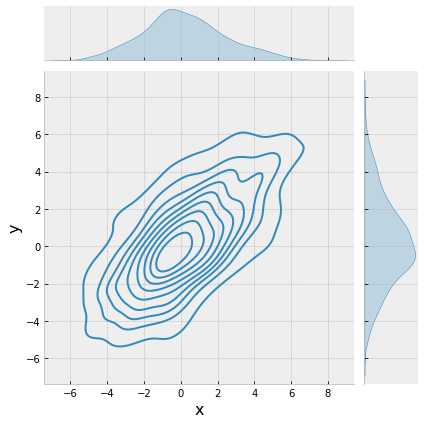

In [185]:
g = sns.jointplot(x=x, y=y, kind='kde', marginal_kws=dict(fill=True), ax=ax)
g.set_axis_labels('x', 'y', fontsize=16)
#g.ax_joint.set_xlabel('new x label', fontweight='bold')
g.figure.tight_layout() 

In [186]:
qX = joint.sum(1)
qY = joint.sum(0)

print(f'Q(X): {np.round(qX,3)}')
print(f'\nQ(Y):{np.round(qY,3)}')

Q(X): [0.023 0.066 0.114 0.249 0.212 0.156 0.095 0.053 0.026 0.005]

Q(Y):[0.023 0.066 0.114 0.245 0.215 0.156 0.096 0.053 0.026 0.005]


### MEASURES

In [187]:
hX = entropy(qX, base=2)
print(f'H(X): {hX:.3f} bits | Emprical Description of X')

hY = entropy(qY, base=2)
print(f'\nH(Y): {hY:.3f} bits | Emprical Description of Y')

H(X): 2.859 bits | Emprical Description of X

H(Y): 2.861 bits | Emprical Description of Y


In [188]:
#pX_Y = (joint.T / qY).T
pX_Y = joint / qY
np.round(pX_Y, 2)

array([[0.22, 0.08, 0.06, 0.02, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.26, 0.18, 0.24, 0.04, 0.03, 0.03, 0.01, 0.  , 0.  , 0.  ],
       [0.17, 0.29, 0.27, 0.14, 0.07, 0.06, 0.01, 0.  , 0.  , 0.  ],
       [0.22, 0.33, 0.26, 0.39, 0.26, 0.17, 0.1 , 0.04, 0.08, 0.  ],
       [0.13, 0.11, 0.12, 0.23, 0.31, 0.24, 0.21, 0.15, 0.  , 0.  ],
       [0.  , 0.02, 0.04, 0.14, 0.19, 0.24, 0.32, 0.08, 0.12, 0.  ],
       [0.  , 0.  , 0.  , 0.03, 0.1 , 0.15, 0.21, 0.32, 0.19, 0.  ],
       [0.  , 0.  , 0.  , 0.02, 0.02, 0.09, 0.11, 0.25, 0.23, 0.2 ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.02, 0.02, 0.17, 0.23, 0.6 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.2 ]])

In [189]:
print(f'Max Entropy: {np.log2(states):.3f} bits')

Max Entropy: 3.322 bits


In [190]:
hX = entropy(qX, base=2)
print(f'H(X): {hX:.3f} bits | Description of X')

hY = entropy(qY, base=2)
print(f'\nH(Y): {hY:.3f} bits | Description of Y')

hX_Y = np.sum(entropy(pX_Y.T, base=2) * qY)
print(f'\nH(X|Y): {hX_Y:.3f} bits | Description of X after observing Y')

H(X): 2.859 bits | Description of X

H(Y): 2.861 bits | Description of Y

H(X|Y): 2.623 bits | Description of X after observing Y


In [191]:
miXY = hX - hX_Y
print(f'I(X:Y): {miXY:.3f} bits | Reduction in the description of X')
print(f'Reduction: {miXY / hX :.3f}%')

I(X:Y): 0.236 bits | Reduction in the description of X
Reduction: 0.083%


In [192]:
hX_Y =  np.sum(qY * np.log2(np.e) * np.apply_along_axis(entropy, 0, pX_Y)) # ESTE NO PUEDE TOMAR MEAN !!!!!
print(f'H(X|Y): {hX_Y:.3f} bits')

H(X|Y): 2.418 bits


In [193]:
miXY = hX - hX_Y
print(f'I(X:Y): {miXY:.3f} bits | Reduction in the description of X')
print(f'Reduction: {miXY / hX :.3f}%')

I(X:Y): 0.440 bits | Reduction in the description of X
Reduction: 0.154%


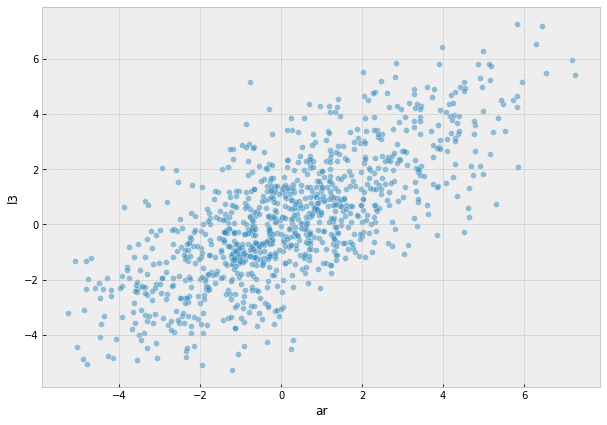

In [194]:
fig = plt.figure(figsize=(10,7))
sns.scatterplot(x='ar', y='l3', data=data, alpha=0.5)
plt.show()

In [197]:
np.corrcoef(x, y)[0,1]

0.6565442633802429

In [198]:
mi = mutual_info_score(None, None, contingency=pxy)
print(f'I(X:Y): {mi:.4f} nits')

I(X:Y): 0.3050 nits


In [199]:
mib = np.log2(np.e) * mi
print(f'I(X:Y): {mib:.4f} bits')

I(X:Y): 0.4401 bits
